# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [2]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [3]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
datosOriginal = pd.read_csv("pokemon_train.csv", encoding = 'latin_1', sep = ',')
datosDF = datosOriginal
nombres_pokemon = datosDF.pop("name")
tipos_pokemon_type1 = datosDF.pop("type1")
tipos_pokemon_type2 = datosDF.pop("type2")
id_pokemon = datosDF.pop("id")

datosClasificarDF = pd.read_csv("pokemon_classify.csv", encoding = 'latin_1', sep = ',')
datosClasificarDF = datosClasificarDF.drop(["name","type1","type2","id"], axis=1)

## SOM Setup
#### Variables definidas por el alumno

In [4]:
# Valores de entradas 
n_entradas_kohonen = len(datosDF.columns) # 22 entradas 
tam_dataset = len(datosDF) # 247 valores

In [5]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 30 # Cambiar
periodo = 4500 # Cambiar
learning_rate = 0.2 # Cambiar
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [6]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = n_entradas_kohonen
num_datos = tam_dataset

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario_inicial = int(lado_mapa/2)

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datosAR = datosDF.to_numpy()
    datosAR = (datosAR - datosAR.min()) / ( datosAR.max() - datosAR.min())
else:
    datosAR = datosDF.to_numpy()
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random((lado_mapa,lado_mapa,num_entradas))
matriz_pesos_original = matriz_pesos # La guardamos para poder comparar en un futuro

#### Funciones para entrenar/clasificar

In [ ]:
# Funcion calcular BMU
def calcular_bmu(patron_entrada, m_pesos):
   # Obtenemos dimensiones de la matriz de pesos para los bucles
   rows = len(m_pesos)
   columns = len(m_pesos[0])
   # Decimos que la ganadora al principio sea la primera neurona
   ganadora = np.linalg.norm(np.array(m_pesos[0][0]) - np.array(patron_entrada))
   Bmu = m_pesos[0][0]
   BmuIndex = np.stack((0,0))
   # Bucle que recorre toda las neuronas
   for x in range(rows):
      for y in range(columns):
         # Obten la distancia euclidea entre la neurona y el patron
         dist = np.linalg.norm(np.array(m_pesos[x][y]) - np.array(patron_entrada))
         # Si la nueva distancia es menor que la ganadora asigna esta neurona como la nueva ganadora
         if dist < ganadora:
            ganadora = dist
            Bmu = m_pesos[x][y]
            BmuIndex = np.stack((x,y))
   return Bmu , BmuIndex

In [ ]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
   learning_rate = lr_inicial * (1 - i/n_iteraciones)
   return learning_rate


In [ ]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   vecindario = 1 + vecindario_inicial * (1 - i/n_iteraciones)
   return vecindario

In [ ]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

In [ ]:
#Funcion Ajuste de matriz de pesos
def ajustarPesos(IndexN , pokemon , learning_rate , matriz_pesos , vecindario):
    # Formula para obtener los pesos nuevos de la BMUW
    matriz_pesos[IndexN[0]][IndexN[1]] += (learning_rate * (pokemon - matriz_pesos[IndexN[0]][IndexN[1]]))
    # Obtenemos las dimensiones para el bucle
    rows = len(matriz_pesos)
    cols = len(matriz_pesos[0])
    # Bucle que recorre todas la neuronas incluida la BMU
    for x in range(rows):
        for y in range(cols):
            vectorNeurona = [x,y] #Guardamos el indice como un vector
            vectorBMU = [IndexN[0],IndexN[1]] #Guardamos el indice como un vecto
            #Calculamos la discacia euclidea entre ambos vectores para determinar como de lejos estan los indices
            dist_euc = np.linalg.norm(np.array(vectorBMU) - np.array(vectorNeurona)) 
            # Si la distancia es menor o igual que el vecindario y no es 0 (caso de la BMU) entonces sabemos que es vecina de BMU
            if(dist_euc <= vecindario and dist_euc != 0):
              # Dime segun la distancia entre la neuroma vecina y la bmu cuanto es el decay del learning rate
              dist_decay = decay(dist_euc,vecindario)
              # Aplico formula de ajuste de pesos a la neurona vecina segun los datos obtenidos
              matriz_pesos[x][y] += (learning_rate * dist_decay * (pokemon -  matriz_pesos[x][y]))  
    return matriz_pesos

## PINTAR HISTOGRAMA

## SOM Entrenamiento

In [ ]:
def Entrenar():
    # Entrena la red con el dataset de entrenamiento
    # Guardamos las variables iniciales para no modificarlas en las iteraciones de entrenamiento
    vecindario = vecindario_inicial
    learning_rate_ajustado = learning_rate
    for x in range(periodo):
        # Imprime la iteracion actual cada 100 iteraciones
        '''
        if(x % 100 == 0 and x != 0):
            print('Iteracion Nº: ',x,end="\r")
        '''
        #Obtenemos un indice aleatorio de nuestro set de pokemon
        numAleatorio = np.random.randint(0, tam_dataset)
        pokemon = datosAR[numAleatorio] 
        #Pasamos el pokemon aleatorio a calcular bmu para que nos devuelva la neurona mas proxima al patron
        Bmu , BmuIndex = calcular_bmu(pokemon,matriz_pesos)
        #Ajustamos la matrix de pesos segun los datos obtenidos
        matriz_pesos = ajustarPesos(BmuIndex , pokemon , learning_rate_ajustado , matriz_pesos , vecindario)
        #Una vez ajustada la matriz de pesos modificamos el learning rate para la siguiente iteracion
        learning_rate_ajustado = variacion_learning_rate(learning_rate, x , periodo)
        #Una vez ajustada la matriz de pesos modificamos el vecindario para la siguiente iteracion
        vecindario = variacion_vecindario(vecindario_inicial , x , periodo)
    return matriz_pesos

    #print('Iteracion Nº: ',x + 1)

## SOM Clasificación

In [ ]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada

def Clasificacion(pokemon , matriz_pesos):

    Mapa_Clasificacion = np.zeros((lado_mapa,lado_mapa,num_entradas))
    Mapa_Activacion = np.zeros((lado_mapa,lado_mapa),dtype=int)
    Mapa_Distancias = np.zeros((lado_mapa,lado_mapa))

    clase = 0

    for poke in pokemon:
        bmu , bmuIndex = calcular_bmu(poke,matriz_pesos)
        Mapa_Activacion[bmuIndex[0],bmuIndex[1]] += 1 # Cada vez que se activa una neurona (x,y de la ganadora ++)
        #print("Neurona gandora: ", bmuIndex)
        Mapa_Clasificacion[bmuIndex[0],bmuIndex[1]] = poke # Se guarda el último color que ha activado la neurona
        # La media de las distancias euclidieas de esa neurona
        Mapa_Distancias[bmuIndex[0],bmuIndex[1]] = (Mapa_Distancias[bmuIndex[0],bmuIndex[1]] + np.linalg.norm(np.array(bmu) - np.array(poke))) / 2 
        
    for x in range(len(Mapa_Activacion)):
        for y in range(len(Mapa_Activacion[0])):
            if Mapa_Activacion[x][y] > 0:
                clase += 1

    #print('Numero de Clases: ', clase)
    return Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias, clase


#Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias = Clasificacion(datosAR, matriz_pesos)

## SOM Prueba

In [ ]:
# Clasifica nuevos patrones

#datosClasificar = np.random.rand(18,100)
datosClasificar = datosAR
#datosClasificar = np.transpose(datosClasificar)

Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias, N_Clases = Clasificacion(datosClasificar, matriz_pesos)
# Funcion para calcular el error de cuantificacion dado un mapa de Distancias
def Calcular_err_cuantificacion(Mapa_Distancias):
    ListaDistancia = []
    for x in range(len(Mapa_Distancias)):
        for y in range(len(Mapa_Distancias[0])):
            if Mapa_Distancias[x][y] != 0:
             ListaDistancia.append(Mapa_Distancias[x][y])
    Media = sum(ListaDistancia) / len(ListaDistancia)
    return Media

# Funcion que devuelve si la segunda bmu es adyacente o no dado un patron
def calcular_err_topologico(patron_entrada, m_pesos):
    rows = len(m_pesos)
    columns = len(m_pesos[0])
    # Asignamos que la ganadora 1 sea la primera neurona y la ganadora 2 la segunda por tener un valor con cual empezar
    ganadora = np.linalg.norm(np.array(m_pesos[0][0]) - np.array(patron_entrada))
    ganadora2 = np.linalg.norm(np.array(m_pesos[0][1]) - np.array(patron_entrada))
    BmuIndex = np.stack((0,0))
    Bmu2Index = np.stack((0,1))
    # Mismo algoritmo que CalcularBMU pero en este se guarda la segunda BMU
    for x in range(rows):
        for y in range(columns):
            dist = np.linalg.norm(np.array(m_pesos[x][y]) - np.array(patron_entrada))
            if dist < ganadora:
                ganadora = dist
                BmuIndex = np.stack((x,y))
            else:
                if dist < ganadora2:
                    ganadora2 = dist
                    Bmu2Index = np.stack((x,y))
    # Devuelve 0 si es adyacente y 1 en el caso contrario
    return (0 if np.linalg.norm(np.array(BmuIndex)-np.array(Bmu2Index)) < 2 else 1)

# Aqui calculamos e imprimimos los errores
print('Error De Cuantificacion: ', Calcular_err_cuantificacion(Mapa_Distancias))

listaX = []
# Dado un set de colores guarda en una lista los valores devueltos
for pokemon in datosClasificar:
    listaX.append(calcular_err_topologico(pokemon,matriz_pesos))
# Calculamos la Media
media = sum(listaX) / len(listaX)
print('Error Topologico: ', media)

### Se prueban los diferentes combinaciones de lado, periodo y coeficiente para encontrar el punto mas optimo

Gráfica lado de capa de kohonen:


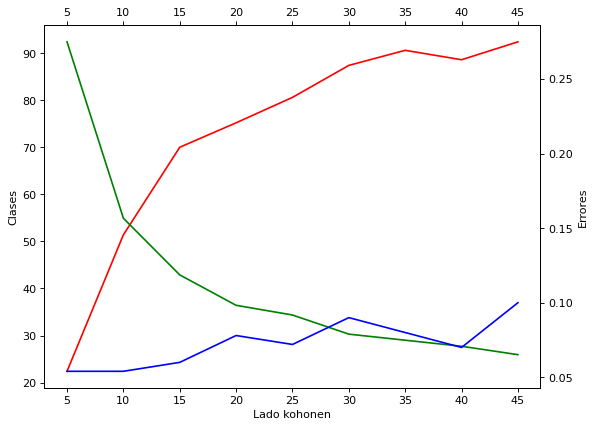

In [170]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
# Valores que tenemos que encontrar
lado_mapa_mat = [i for i in range(5,50,5)] # lista de 5 a 50 en intervalos de 5
periodo1 = [i*num_colores for i in range(1,21,1)]
periodo2 = [i*num_colores for i in range(20,81,10)]
periodo_mat = []
for i in [periodo1, periodo2]:
    for j in i:
        periodo_mat.append(j) # guardo todos los posibles periodos
learning_rate_mat = [float(i/100) for i in range(5,51,5)] # de 0.05 a 0.5 guardados

# ---------------------------------------------------------------------------------------------------------------
# Primero encontramos el mejor lado mapa usando de periodo periodo_mat[periodo_mat.length/2] y learning rate 0.2
# ---------------------------------------------------------------------------------------------------------------

clase_graf = []
cuant_graf = []
topo_graf = []
precision = 5 # queremos que los datos resultantes sean la media entre x resultados obtenidos ya que son aleatorios
for i in lado_mapa_mat:
    # Guardo los datos en concreto:
    lado_mapa = i
    periodo = periodo_mat[int(len(periodo_mat)/2)]
    learning_rate = 0.2

    num_clase = []
    errCuant = []
    errTopo = []
    print('Lado mapa: ',i,end="\r")
    for inc in range(precision):
        matriz_pesos = np.random.random((lado_mapa,lado_mapa,num_entradas))
        # Se entrena
        matriz_pesos = Entrenar(matriz_pesos)
        # Se clasifica
        Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias, n = Clasificacion(datosAR, matriz_pesos) # ha sido cambiado para hacer return del numero de clases tambien
        num_clase.append(n)
        # Se calcula el error cuantificacion
        errCuant.append(Calcular_err_cuantificacion(Mapa_Distancias))
        # Calculamos el error topologico
        listaX = []
        for pokemon in datosClasificar:
            listaX.append(calcular_err_topologico(pokemon,matriz_pesos))
        # Calculamos la Media
        errTopo.append(sum(listaX) / len(listaX))
    # Hacemos la media de los 5 elementos
    num_clase = np.mean(num_clase)
    errCuant = np.mean(errCuant)
    errTopo = np.mean(errTopo)
    # Guardo todo en las matrices
    clase_graf.append(num_clase)
    cuant_graf.append(errCuant)
    topo_graf.append(errTopo)

print("Gráfica lado de capa de kohonen:")
# Se hace una gráfica con los datos obtenidos
plt.xlabel('Lado kohonen')
plt.ylabel('Clases')
# Influencia del lado KHONONEN en número de clases
linea_clases = plt.plot(lado_mapa_mat,clase_graf,'r')
plt.twinx()
# Influencia del lado KHONONEN en errores
plt.ylabel('Errores')
# Error cuantificable
linea_cuantificable = plt.plot(lado_mapa_mat,cuant_graf,'g') 
plt.twiny()
# Error topológico
linea_topologico = plt.plot(lado_mapa_mat,topo_graf,'b') 

Gráfica coeficiente de aprendizaje:


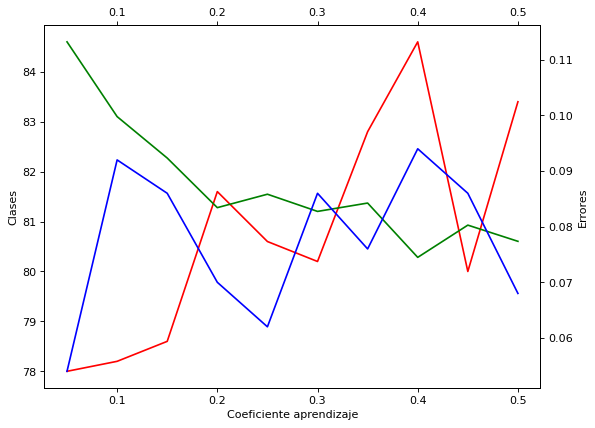

In [171]:
# ---------------------------------------------------------------------------------------------------------------------------------------
# Ahora que podemos ver que lado de la capa de kohonen, vemos qué coeficiente de aprendizage es mas eficaz (lo introducimos lo primero)
# ---------------------------------------------------------------------------------------------------------------------------------------
lado = 25

clase_graf = []
cuant_graf = []
topo_graf = []
precision = 5 # queremos que los datos resultantes sean la media entre x resultados obtenidos ya que son aleatorios
for i in learning_rate_mat:
    # Guardo los datos en concreto:
    lado_mapa = lado
    periodo = periodo_mat[int(len(periodo_mat)/2)]
    learning_rate = i

    num_clase = []
    errCuant = []
    errTopo = []
    print('Coef. aprendizage: ',i,end="\r")
    for inc in range(precision):
        matriz_pesos = np.random.random((lado_mapa,lado_mapa,num_entradas))
        # Se entrena
        matriz_pesos = Entrenar(matriz_pesos)
        # Se clasifica
        Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias, n = Clasificacion(datosAR, matriz_pesos) # ha sido cambiado para hacer return del numero de clases tambien
        num_clase.append(n)
        # Se calcula el error cuantificacion
        errCuant.append(Calcular_err_cuantificacion(Mapa_Distancias))
        # Calculamos el error topologico
        listaX = []
        for pokemon in datosClasificar:
            listaX.append(calcular_err_topologico(pokemon,matriz_pesos))
        # Calculamos la Media
        errTopo.append(sum(listaX) / len(listaX))
    # Hacemos la media de los 5 elementos
    num_clase = np.mean(num_clase)
    errCuant = np.mean(errCuant)
    errTopo = np.mean(errTopo)
    # Guardo todo en las matrices
    clase_graf.append(num_clase)
    cuant_graf.append(errCuant)
    topo_graf.append(errTopo)

print("Gráfica coeficiente de aprendizaje:")
figure(figsize=(8, 6), dpi=80)
plt.xlabel('Coeficiente aprendizaje')
plt.ylabel('Clases')
# Influencia del Coeficiente en número de clases
linea_clases = plt.plot(learning_rate_mat,clase_graf,'r')
plt.twinx()
# Influencia del Coeficiente en errores
plt.ylabel('Errores')
# Error cuantificable
linea_cuantificable = plt.plot(learning_rate_mat,cuant_graf,'g') 
plt.twiny()
# Error topológico
linea_topologico = plt.plot(learning_rate_mat,topo_graf,'b') 

In [1]:
# ------------------------------------------------------------------------------------------------------------
# Ahora ya sabemos el tamaño del lado y el coeficiente de aprendizaje mas óptimo, queda averiguar el periodo 
# ------------------------------------------------------------------------------------------------------------
lado = 25
coef = 0.3

clase_graf = []
cuant_graf = []
topo_graf = []
precision = 5 # queremos que los datos resultantes sean la media entre x resultados obtenidos ya que son aleatorios
for i in periodo_mat:
    # Guardo los datos en concreto:
    lado_mapa = lado
    periodo = i
    learning_rate = coef

    num_clase = []
    errCuant = []
    errTopo = []
    print('Periodo: ',i,end="\r")
    for inc in range(precision):
        matriz_pesos = np.random.random((lado_mapa,lado_mapa,num_entradas))
        # Se entrena
        matriz_pesos = Entrenar(matriz_pesos)
        # Se clasifica
        Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias, n = Clasificacion(datosAR, matriz_pesos) # ha sido cambiado para hacer return del numero de clases tambien
        num_clase.append(n)
        # Se calcula el error cuantificacion
        errCuant.append(Calcular_err_cuantificacion(Mapa_Distancias))
        # Calculamos el error topologico
        listaX = []
        for pokemon in datosClasificar:
            listaX.append(calcular_err_topologico(pokemon,matriz_pesos))
        # Calculamos la Media
        errTopo.append(sum(listaX) / len(listaX))
    # Hacemos la media de los 5 elementos
    num_clase = np.mean(num_clase)
    errCuant = np.mean(errCuant)
    errTopo = np.mean(errTopo)
    # Guardo todo en las matrices
    clase_graf.append(num_clase)
    cuant_graf.append(errCuant)
    topo_graf.append(errTopo)

print("Gráfica periodo:")
figure(figsize=(30, 5), dpi=80)
plt.xlabel('Periodo')
plt.ylabel('Clases')
# Influencia periodo en número de clases
linea_clases = plt.plot(periodo_mat,clase_graf,'r')
plt.twinx()
# Influencia periodo en errores
plt.ylabel('Errores')
# Error cuantificable
linea_cuantificable = plt.plot(periodo_mat,cuant_graf,'g') 
plt.twiny()
# Error topológico
linea_topologico = plt.plot(periodo_mat,topo_graf,'b') 

NameError: name 'periodo_mat' is not defined

In [173]:
# código de prueba 
lado_mapa_mat = [i for i in range(5,50,5)] 
print(lado_mapa_mat)
num_colores = 300
periodo1 = [i*num_colores for i in range(1,21,1)]
periodo2 = [i*num_colores for i in range(20,81,10)]
periodo_mat = []
for i in [periodo1, periodo2]:
    for j in i:
        periodo_mat.append(j)
print(periodo_mat)
learning_rate_mat = [float(i/100) for i in range(5,51,5)]
print(learning_rate_mat)
print(periodo_mat[int(len(periodo_mat)/2)])

[5, 10, 15, 20, 25, 30, 35, 40, 45]
[300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000, 6000, 9000, 12000, 15000, 18000, 21000, 24000]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
4200
